In [3]:
import backtesting

C:\Users\HP\anaconda3\Lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [68]:
from backtesting.test import SMA
import pandas as pd
import glob

In [72]:
filename = "NFO_NIFTY_Future"
glob.glob(f"{filename}*.csv")

['NFO_NIFTY_Future_Dec2023.csv',
 'NFO_NIFTY_Future_Feb2024.csv',
 'NFO_NIFTY_Future_Jan2024.csv',
 'NFO_NIFTY_Future_Mar2024.csv']

In [78]:
all_csv_files = glob.glob(f"{filename}*.csv")

# read all csv files at once
df = pd.concat(pd.read_csv(csv_file) for csv_file in all_csv_files)
df.shape

(28924, 14)

In [83]:
df1 = df[['datetime','open','high','low','close','volume']]

In [89]:
df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")

C:\Users\HP\AppData\Local\Temp\ipykernel_15252\1482150303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['datetime'] = pd.to_datetime(df1.datetime,format="mixed")


In [119]:
data = df1.set_index('datetime')
data.rename(columns = {"open": "Open", "high": "High", "low":"Low", "close": "Close"}, inplace = True)

In [91]:
data

,Open,High,Low,Close,volume
datetime,,,,,
2023-01-12 09:15:00,20303.25,20335.20,20303.25,20333.00,122200
2023-01-12 09:16:00,20330.45,20330.70,20320.20,20327.00,66100
2023-01-12 09:17:00,20325.85,20335.95,20324.35,20335.95,79700
2023-01-12 09:18:00,20336.45,20349.00,20336.45,20347.00,61350
2023-01-12 09:19:00,20348.00,20350.00,20346.00,20348.05,52650
...,...,...,...,...,...
2024-03-28 15:25:00,22328.95,22329.90,22325.10,22329.90,34300
2024-03-28 15:26:00,22329.90,22330.80,22327.65,22329.50,22000
2024-03-28 15:27:00,22328.00,22329.60,22327.00,22328.50,23300


In [142]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
sma200 = SMA(data.Close, 200)
sma300 = SMA(data.Close, 300)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close
data['X_SMA200'] = (close - sma200) / close


data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close
data['X_DELTA_SMA100'] = (sma100 - sma200) / close
data['X_DELTA_SMA200'] = (sma200 - sma300) / close


# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2024-03-01', '2024-03-30')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [127]:
data.head(2)

,Open,High,Low,Close,volume,X_SMA10,X_SMA20,X_SMA50,X_DELTA_SMA10,X_DELTA_SMA20,...,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour,X_SMA100,X_SMA200,X_DELTA_SMA50,X_DELTA_SMA100
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-12 13:23:00,20380.0,20383.0,20380.0,20383.00,2400.0,-0.000023,-0.000119,-0.000074,-0.000096,0.000045,...,0.000463,-0.000217,0.000680,1.0,3.0,13.0,-0.000008,0.000118,0.000066,0.000126
2023-01-12 13:24:00,20383.0,20385.0,20383.0,20384.95,2650.0,0.000082,0.000004,0.000013,-0.000078,0.000009,...,0.000270,-0.000266,0.000536,1.0,3.0,13.0,0.000087,0.000214,0.000074,0.000127


In [143]:
data['X_Sentiment'].value_counts()

X_Sentiment
1.0    21230
0.0     6848
Name: count, dtype: int64

In [144]:
import numpy as np


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.9600428112736354


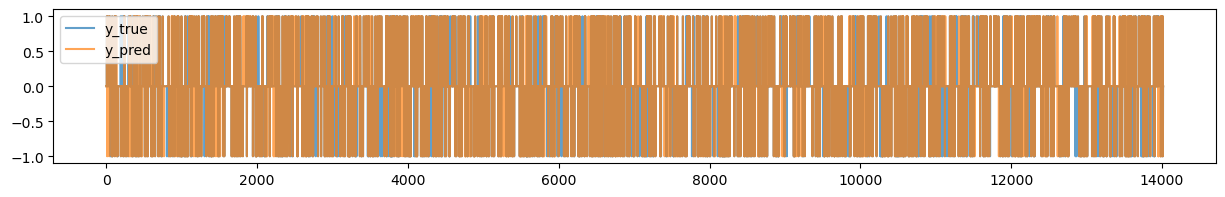

In [145]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(3)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [132]:
y_test, y_pred

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [61]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'volume', 'X_SMA10', 'X_SMA20',
       'X_SMA50', 'X_SMA100', 'X_DELTA_SMA10', 'X_DELTA_SMA20',
       'X_DELTA_SMA50', 'X_MOM', 'X_BB_upper', 'X_BB_lower', 'X_BB_width',
       'X_Sentiment', 'X_day', 'X_hour'],
      dtype='object')

In [146]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(9)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_15252\767194509.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_15252\767194509.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-05-12 10:51:00
End                       2024-03-28 15:29:00
Duration                    321 days 04:38:00
Exposure Time [%]                    14.55588
Equity Final [$]                   9961.65592
Equity Peak [$]                   10292.52669
Return [%]                          -0.383441
Buy & Hold Return [%]                 6.72382
Return (Ann.) [%]                   -1.265774
Volatility (Ann.) [%]                9.637472
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.665483
Avg. Drawdown [%]                   -0.524254
Max. Drawdown Duration       16 days 04:49:00
Avg. Drawdown Duration        0 days 23:40:00
# Trades                                   50
Win Rate [%]                             50.0
Best Trade [%]                       1.115401
Worst Trade [%]                     -0.560203
Avg. Trade [%]                    

Classification accuracy:  0.958085923856095


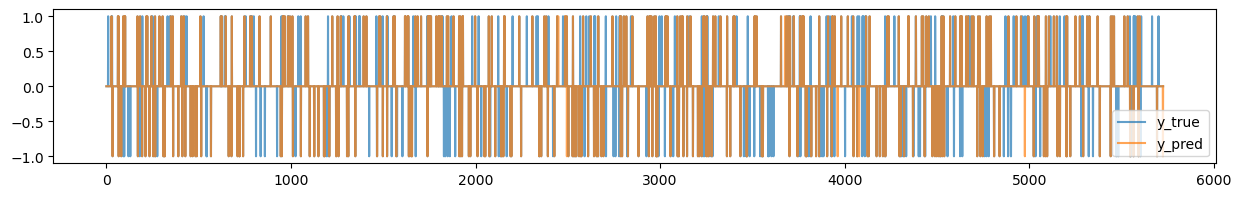

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

clf = RandomForestClassifier(50)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [135]:
from backtesting import Backtest, Strategy

N_TRAIN = 20000


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = RandomForestClassifier(50)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

C:\Users\HP\AppData\Local\Temp\ipykernel_15252\430983043.py:61: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
C:\Users\HP\AppData\Local\Temp\ipykernel_15252\430983043.py:61: UserWarning: Data index is not sorted in ascending order. Sorting.
  bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)


Start                     2023-01-12 13:23:00
End                       2024-03-28 15:29:00
Duration                    441 days 02:06:00
Exposure Time [%]                     8.37983
Equity Final [$]                   9788.94124
Equity Peak [$]                   10215.92437
Return [%]                          -2.110588
Buy & Hold Return [%]                9.537605
Return (Ann.) [%]                   -6.659687
Volatility (Ann.) [%]                6.140472
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.747551
Avg. Drawdown [%]                   -0.487422
Max. Drawdown Duration       29 days 02:22:00
Avg. Drawdown Duration        1 days 13:50:00
# Trades                                   30
Win Rate [%]                        46.666667
Best Trade [%]                       0.692453
Worst Trade [%]                     -0.601095
Avg. Trade [%]                    